In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load the Excel file
file_path = r"C:\Users\TomiNordi2m\OneDrive - i2m Unternehmensentwicklung GmbH\Documents\Python\dCEO\Final_Cleaned_Basic_Energy_Data_Wessely_TN.xlsx"
# file_path = r"C:\Users\TomiNordi2m\OneDrive - i2m Unternehmensentwicklung GmbH\Documents\Python\dCEO\Konrad Energy Data Aggregated.xlsx"
excel_file = pd.ExcelFile(file_path)


# Load the data from the identified sheet
df = excel_file.parse('Summary')

# Show the first few rows and column names to understand the structure
df.head()


,Unnamed: 0,DateTime,Grid Consumption [kW],Grid Feed-in [kW],PV Production [kW],Load Profile [kW],Unnamed: 6,Unnamed: 7
0,0,2024-01-01 00:00:00,39.12,0.0,0.0,39.12,NaN,0.008166
1,1,2024-01-01 00:15:00,39.12,0.0,0.0,39.12,NaN,NaN
2,2,2024-01-01 00:30:00,32.88,0.0,0.0,32.88,NaN,NaN
3,3,2024-01-01 00:45:00,32.32,0.0,0.0,32.32,NaN,NaN
4,4,2024-01-01 01:00:00,32.72,0.0,0.0,32.72,NaN,NaN


### Customer Tariff

In [ ]:
tariff = {
    # Energy supply (Stromlieferung)
    'arbeitspreis': 0.179268,               # €/kWh (from "Verbrauchspreis")
    
    'leistungspreis_lieferant': 10.00,      # €/kW
    'preiszonentrennung': 0.00476,          # €/kWh

    # Grid fees (Netznutzung)
    'leistungspreis_netznutzung': 51.84,    # €/kW
    'arbeitspreis_netznutzung_HT': 0.0107,  # €/kWh
    'arbeitspreis_netznutzung_NT': 0.0107,  # €/kWh
    'netzverlustentgelt': 0.0039,           # €/kWh

    # Combined peak power cost
    'leistungspreis_gesamt': 61.84,         # €/kW (sum of supplier + grid)

    #Feed-in Tariff
    'einspeisetarif': 0.07  # €/kWh
}

gas_tarif = {
    'arbeitspreis_gas': 0.17,       # €/kWh (Verbrauchspreis Gas)            
}



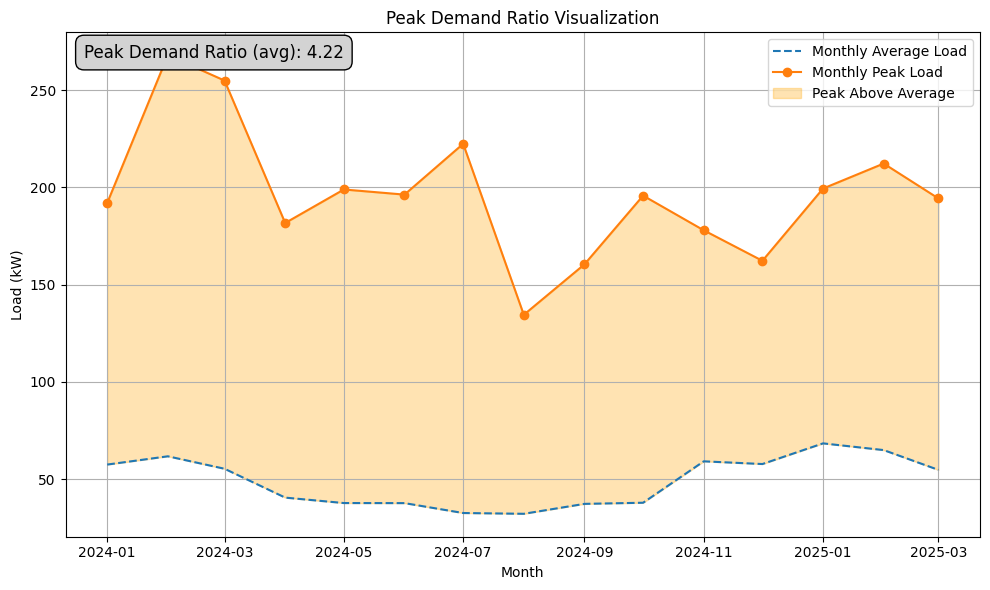

In [3]:
# Convert Date column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Group data by month
df['month'] = df['DateTime'].dt.to_period('M')
monthly_avg = df.groupby('month')['Load Profile [kW]'].mean()
monthly_peak = df.groupby('month')['Load Profile [kW]'].max()
monthly_dates = monthly_avg.index.to_timestamp()

# Convert to numpy arrays for plotting compatibility
monthly_dates = monthly_dates.to_numpy()
monthly_avg = monthly_avg.to_numpy()
monthly_peak = monthly_peak.to_numpy()

# peak demand ratio 
peak_demand_ratio_value = (monthly_peak / monthly_avg).mean()

# Plot with KPI annotation
plt.figure(figsize=(10, 6))
plt.plot(monthly_dates, monthly_avg, label='Monthly Average Load', linestyle='--')
plt.plot(monthly_dates, monthly_peak, label='Monthly Peak Load', marker='o')
plt.fill_between(monthly_dates, monthly_avg, monthly_peak, color='orange', alpha=0.3, label='Peak Above Average')

plt.text(
    0.02, 0.95,
    f"Peak Demand Ratio (avg): {peak_demand_ratio_value:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.title('Peak Demand Ratio Visualization')
plt.xlabel('Month')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Peak Shaving Savings

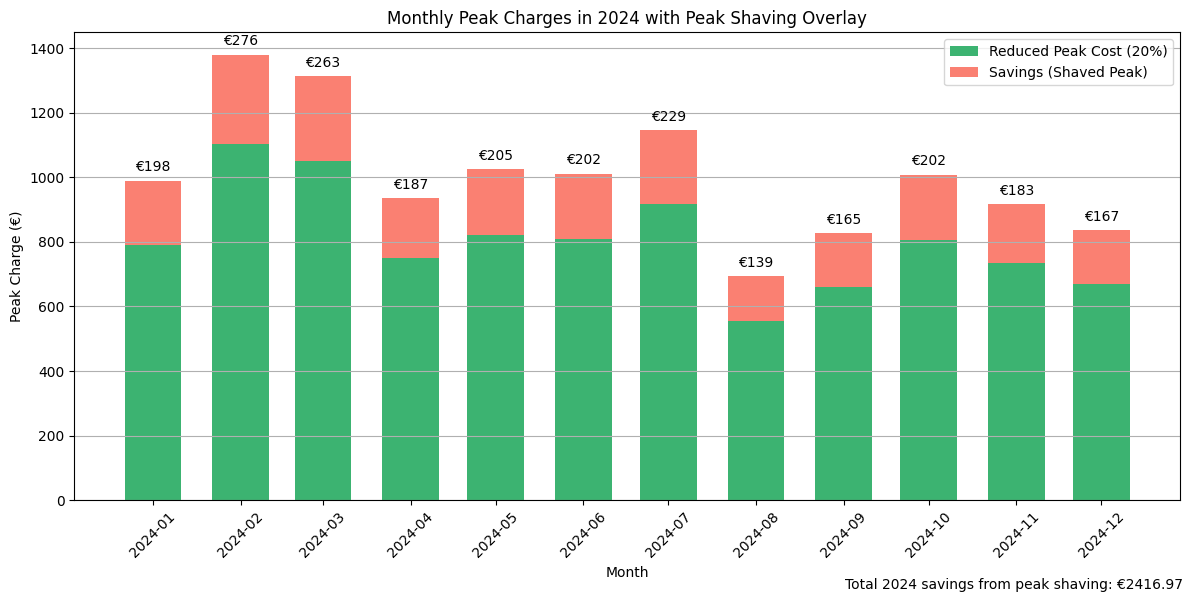

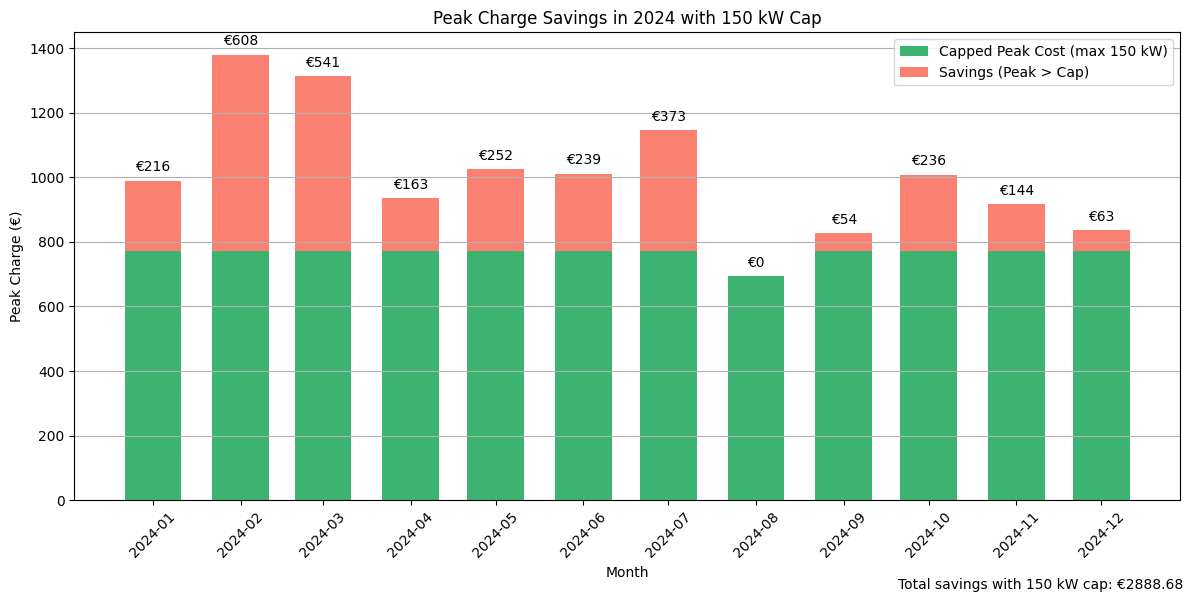

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to 2024 only
monthly_peak_series = df.groupby('month')['Load Profile [kW]'].max()
monthly_peak_2024 = monthly_peak_series[monthly_peak_series.index.year == 2024]

# Tariff rate correction
monthly_rate = tariff['leistungspreis_gesamt'] / 12  # €/kW/month

# Calculate costs for 2024
original_costs = monthly_peak_2024 * monthly_rate
reduced_costs = monthly_peak_2024 * (1 - 0.2) * monthly_rate
savings_per_month = original_costs - reduced_costs

# X-axis
x = pd.to_datetime(monthly_peak_2024.index.to_timestamp())

# Plot
plt.figure(figsize=(12, 6))

# Base: reduced cost
bars1 = plt.bar(x, reduced_costs, width=20, label='Reduced Peak Cost (20%)', color='mediumseagreen')

# Overlay: savings
bars2 = plt.bar(x, savings_per_month, bottom=reduced_costs, width=20, label='Savings (Shaved Peak)', color='salmon')

# Add annotations above each full bar
for i in range(len(x)):
    full_height = reduced_costs.iloc[i] + savings_per_month.iloc[i]
    plt.text(
        x[i], full_height + 20,  # 20 € offset for readability
        f"€{savings_per_month.iloc[i]:.0f}",
        ha='center', va='bottom', fontsize=10
    )

# Formatting
plt.xticks(ticks=x, labels=x.strftime('%Y-%m'), rotation=45)
plt.xlabel('Month')
plt.ylabel('Peak Charge (€)')
plt.title('Monthly Peak Charges in 2024 with Peak Shaving Overlay')
plt.grid(axis='y')
plt.legend()

# Annotate total savings
total_savings = savings_per_month.sum()
plt.figtext(0.99, 0.01, f"Total 2024 savings from peak shaving: €{total_savings:.2f}",
            horizontalalignment='right')

plt.tight_layout()
plt.show()

# Ensure 'month' column exists
df['month'] = df['DateTime'].dt.to_period('M')

#-----------------------------

# Define peak limit in kW
peak_limit_kw = 150

# Get 2024 monthly peak values
monthly_peak_series = df.groupby('month')['Load Profile [kW]'].max()
monthly_peak_2024 = monthly_peak_series[monthly_peak_series.index.year == 2024]

# Apply the peak cap
capped_peaks = monthly_peak_2024.clip(upper=peak_limit_kw)

# Calculate monthly costs
monthly_rate = tariff['leistungspreis_gesamt'] / 12  # €/kW/month
original_costs = monthly_peak_2024 * monthly_rate
capped_costs = capped_peaks * monthly_rate
savings_per_month = original_costs - capped_costs

# X-axis setup
x = pd.to_datetime(monthly_peak_2024.index.to_timestamp())

# Plot the capped peak cost + savings
plt.figure(figsize=(12, 6))
plt.bar(x, capped_costs, width=20, label=f'Capped Peak Cost (max {peak_limit_kw} kW)', color='mediumseagreen')
plt.bar(x, savings_per_month, bottom=capped_costs, width=20, label='Savings (Peak > Cap)', color='salmon')

# Add savings labels above each bar
for i in range(len(x)):
    full_height = capped_costs.iloc[i] + savings_per_month.iloc[i]
    plt.text(
        x[i], full_height + 20,
        f"€{savings_per_month.iloc[i]:.0f}",
        ha='center', va='bottom', fontsize=10
    )

# Formatting
plt.xticks(ticks=x, labels=x.strftime('%Y-%m'), rotation=45)
plt.xlabel('Month')
plt.ylabel('Peak Charge (€)')
plt.title(f'Peak Charge Savings in 2024 with {peak_limit_kw} kW Cap')
plt.grid(axis='y')
plt.legend()

# Total savings annotation
total_savings = savings_per_month.sum()
plt.figtext(0.99, 0.01, f"Total savings with {peak_limit_kw} kW cap: €{total_savings:.2f}",
            horizontalalignment='right')

plt.tight_layout()
plt.show()




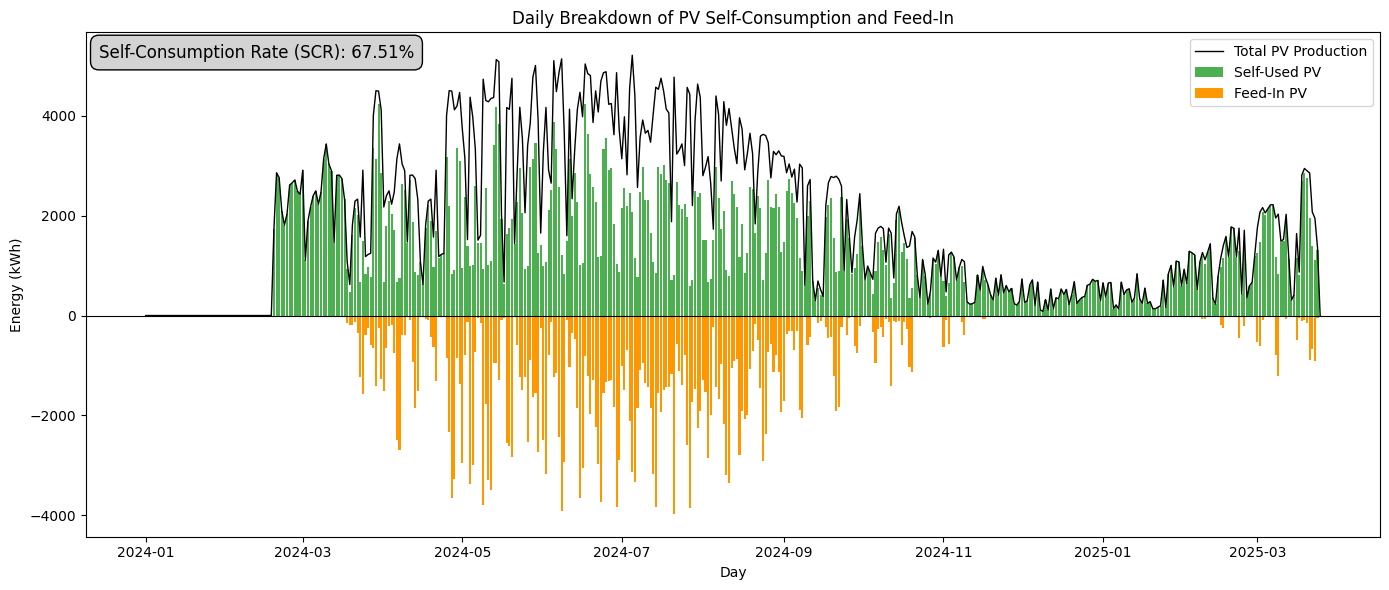

In [5]:

# Prepare columns
df['timestamp'] = pd.to_datetime(df['DateTime'])
df['pv_production'] = df['PV Production [kW]']
df['grid_feed_in'] = df['Grid Feed-in [kW]']

# Calculate 15-min self-consumed PV
df['self_used'] = (df['pv_production'] - df['grid_feed_in']).clip(lower=0)

# Aggregate daily values
df['date'] = df['timestamp'].dt.date
daily_data = df.groupby('date').agg({
    'pv_production': 'sum',
    'self_used': 'sum',
    'grid_feed_in': 'sum'
})

daily_data['self_used_pos'] = daily_data['self_used']
daily_data['feed_in_neg'] = -daily_data['grid_feed_in']  # for downward plotting

# Calculate total SCR
total_scr = daily_data['self_used'].sum() / daily_data['pv_production'].sum()

# Plot
plt.figure(figsize=(14, 6))
plt.bar(daily_data.index, daily_data['self_used_pos'], color='#4CAF50', label='Self-Used PV')
plt.bar(daily_data.index, daily_data['feed_in_neg'], color='#FF9800', label='Feed-In PV')
plt.plot(daily_data.index, daily_data['pv_production'], color='black', linewidth=1.0, label='Total PV Production')

plt.text(
    0.01, 0.95,
    f"Self-Consumption Rate (SCR): {total_scr:.2%}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.axhline(0, color='black', linewidth=0.8)
plt.title('Daily Breakdown of PV Self-Consumption and Feed-In')
plt.ylabel('Energy (kWh)')
plt.xlabel('Day')
plt.legend()
plt.tight_layout()
plt.show()



###SCR Savings

In [6]:
# Set tariff values
einspeisetarif = 0.07  # €/kWh (assumed feed-in price)
strompreis = (
    tariff['arbeitspreis']
    + tariff['arbeitspreis_netznutzung_HT']
    + tariff['preiszonentrennung']
    + tariff['netzverlustentgelt']
)
preis_diff = strompreis - einspeisetarif


# Total PV production and current SCR
total_pv_kwh = df['PV Production [kW]'].sum()
current_scr = total_scr 

# Target SCR (adjust this value as needed)
target_scr = 0.80
delta_scr = target_scr - current_scr

# Calculate additional self-used energy and savings
additional_self_use_kwh = delta_scr * total_pv_kwh
scr_savings = additional_self_use_kwh * preis_diff

print(f"If SCR increases from {current_scr:.1%} to {target_scr:.1%},")
print(f"then additional {additional_self_use_kwh:.0f} kWh self-used saves €{scr_savings:.2f}")


If SCR increases from 67.5% to 80.0%,
then additional 106791 kWh self-used saves €13736.33


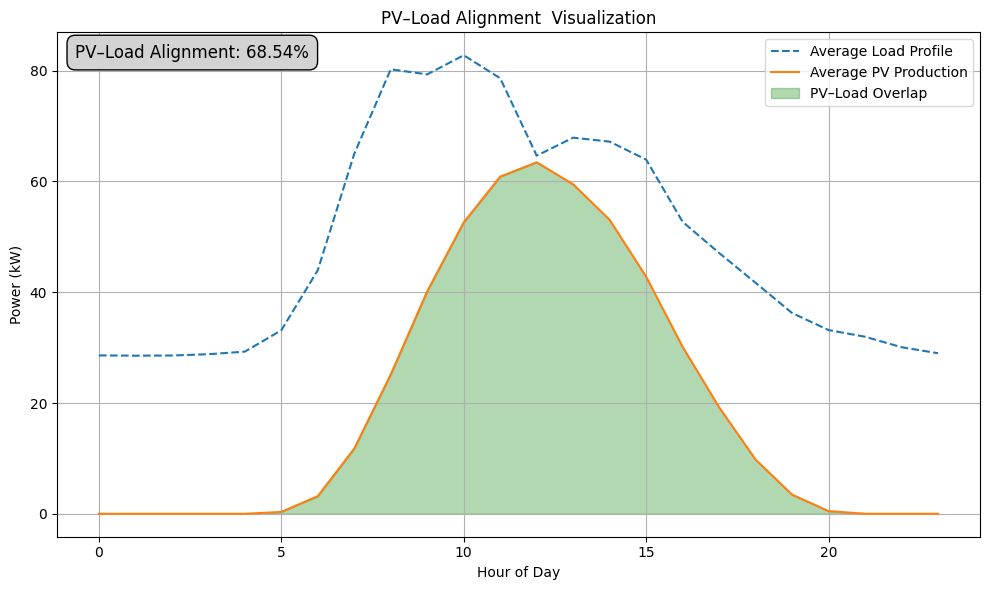

In [7]:
# Convert Date column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Rename for simplicity (optional)
df['timestamp'] = df['DateTime']
df['load'] = df['Load Profile [kW]']
df['pv_production'] = df['PV Production [kW]']

# --- Calculate PV–Load Alignment  ---
df['pv_used_direct'] = df[['load', 'pv_production']].min(axis=1)
lpai = df['pv_used_direct'].sum() / df['pv_production'].sum()

# --- Create average daily load and PV production profile ---
df['hour'] = df['timestamp'].dt.hour
average_profile = df.groupby('hour')[['load', 'pv_production']].mean()

# Prepare values for plotting
x_vals = average_profile.index.to_numpy()
load_vals = average_profile['load'].to_numpy()
pv_vals = average_profile['pv_production'].to_numpy()
overlap_vals = average_profile[['load', 'pv_production']].min(axis=1).to_numpy()

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(x_vals, load_vals, label='Average Load Profile', linestyle='--')
plt.plot(x_vals, pv_vals, label='Average PV Production', linestyle='-')
plt.fill_between(x_vals, overlap_vals, color='green', alpha=0.3, label='PV–Load Overlap')

plt.text(
    0.02, 0.95,
    f"PV–Load Alignment: {lpai:.2%}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.title('PV–Load Alignment  Visualization')
plt.xlabel('Hour of Day')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Energy Split

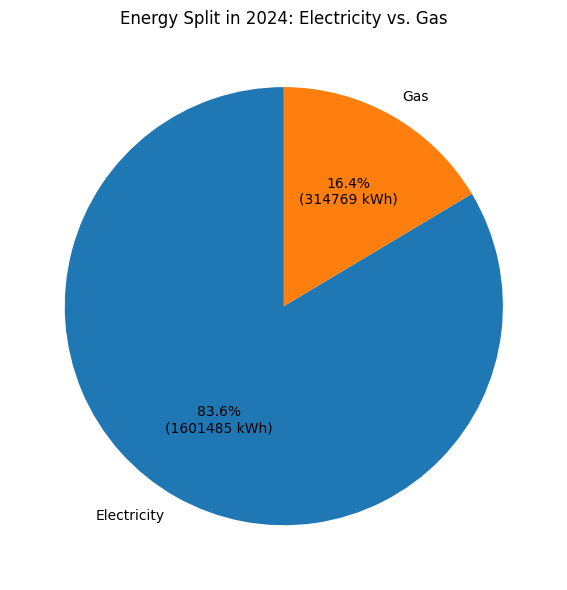

In [8]:
# Filter electricity load for 2024
df_2024 = df[df['DateTime'].dt.year == 2024]
total_electricity_kwh_2024 = df_2024['Load Profile [kW]'].sum()

# Gas energy from the 2024 gas bill (manually extracted in MWh and converted to kWh)
# According to the earlier gas bill (Jahresrechnung 2024...), total was ~314,769 kWh
total_gas_kwh_2024 = 314_769  # already in kWh

# Compute total energy and share
total_energy_kwh_2024 = total_electricity_kwh_2024 + total_gas_kwh_2024
electricity_share = total_electricity_kwh_2024 / total_energy_kwh_2024
gas_share = total_gas_kwh_2024 / total_energy_kwh_2024

# Prepare data for plotting
labels = ['Electricity', 'Gas']
sizes = [electricity_share, gas_share]
values = [total_electricity_kwh_2024, total_gas_kwh_2024]

# Plot energy split pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%\n({p/100*total_energy_kwh_2024:.0f} kWh)', startangle=90)
plt.title('Energy Split in 2024: Electricity vs. Gas')
plt.tight_layout()
plt.show()


### Gas Electrification - Heating Cost Comparison: Gas vs. Electric


In [ ]:
# --- Heating Cost Comparison: Gas vs. Electric (COP = 1) ---

# Assumptions
total_gas_kwh_2024 = 50210.4  # from the gas bill
cop = 1.0  # resistive heating = 1, heat pump =3

# Cost of gas heating (from your gas_tarif dictionary)
total_gas_cost = total_gas_kwh_2024 * gas_tarif['arbeitspreis_gas']

# PV electricity cost (opportunity cost of using it for heating instead of feeding in)
strompreis = (
    tariff['arbeitspreis'] +
    tariff['arbeitspreis_netznutzung_HT'] +
    tariff['preiszonentrennung'] +
    tariff['netzverlustentgelt']
)
pv_self_use_price_per_kwh = strompreis - tariff['einspeisetarif']

# Cost of electric heating using PV
electric_heating_cost = total_gas_kwh_2024 * (pv_self_use_price_per_kwh / cop)

# Savings
electrification_savings = total_gas_cost - electric_heating_cost

# --- Output (Formatted) ---
print(f"Gas Heating (50,210.4 kWh):     €{total_gas_cost:,.2f}")
print(f"Electric Heating (COP = {cop}):     €{electric_heating_cost:,.2f}")
print(f"Estimated Annual Savings:       €{electrification_savings:,.2f}")




Gas Heating (50,210.4 kWh):     €8,535.77
Electric Heating (COP = 1.0):     €6,458.46
Estimated Annual Savings:       €2,077.30


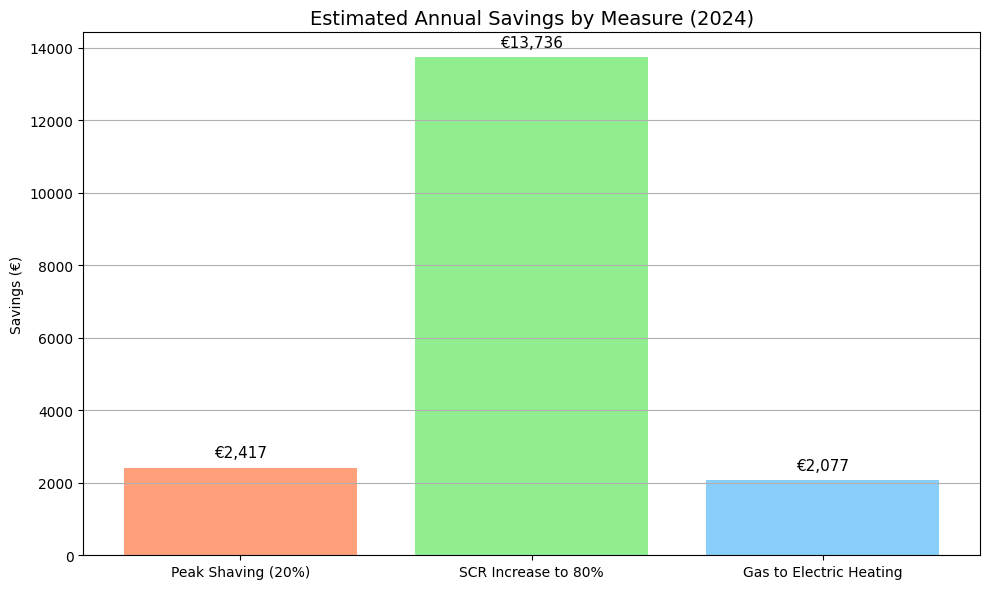

In [21]:
# --- Final Summary of All Estimated Annual Savings (2024) ---

# Recompute the price difference for PV self-use
strompreis = (
    tariff['arbeitspreis'] +
    tariff['arbeitspreis_netznutzung_HT'] +
    tariff['preiszonentrennung'] +
    tariff['netzverlustentgelt']
)
einspeisetarif = tariff['einspeisetarif']
preis_diff = strompreis - einspeisetarif

# 1. Peak Shaving Savings (20%)
monthly_peak_2024 = df.groupby('month')['Load Profile [kW]'].max()
monthly_peak_2024 = monthly_peak_2024[monthly_peak_2024.index.year == 2024]
monthly_rate = tariff['leistungspreis_gesamt'] / 12
peak_shaving_savings = (monthly_peak_2024 * monthly_rate * 0.2).sum()

# 2. SCR Improvement Savings
target_scr = 0.80
delta_scr = target_scr - total_scr
additional_self_use_kwh = delta_scr * df['PV Production [kW]'].sum()
scr_savings = additional_self_use_kwh * preis_diff

# 3. Gas Electrification Savings (COP = 1)
gas_electrification_savings = total_gas_cost - electric_heating_cost

# --- Plot ---
labels = ['Peak Shaving (20%)', 'SCR Increase to 80%', 'Gas to Electric Heating']
savings = [peak_shaving_savings, scr_savings, gas_electrification_savings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, savings, color=['#FFA07A', '#90EE90', '#87CEFA'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 200, f"€{height:,.0f}",
             ha='center', va='bottom', fontsize=11)

plt.title('Estimated Annual Savings by Measure (2024)', fontsize=14)
plt.ylabel('Savings (€)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
